In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [5]:

train_dir = "/content/drive/MyDrive/dataset/train"
test_dir = "/content/drive/MyDrive/dataset/test"


In [11]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)  # Loading test data

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)  # Loading test data


In [15]:
model = models.resnet50(pretrained=True)


In [16]:
for param in model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [10]:
num_epochs = 300
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Initialize variables to track total accuracy across all epochs
total_train_correct = 0
total_train_samples = 0
total_test_correct = 0
total_test_samples = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Track the total correct and total samples
        total_train_correct += correct
        total_train_samples += total

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)

    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:  # Using test_loader instead of val_loader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Track the total correct and total samples for testing
            total_test_correct += correct
            total_test_samples += total

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

# Calculate total accuracy
total_train_accuracy = 100. * total_train_correct / total_train_samples
total_test_accuracy = 100. * total_test_correct / total_test_samples

print(f"Total Train Accuracy: {total_train_accuracy:.2f}%")
print(f"Total Test Accuracy: {total_test_accuracy:.2f}%")


Epoch 1/300, Train Loss: 2.1506, Train Acc: 17.50%, Test Loss: 2.0510, Test Acc: 24.31%
Epoch 2/300, Train Loss: 1.9929, Train Acc: 34.43%, Test Loss: 1.8998, Test Acc: 44.75%
Epoch 3/300, Train Loss: 1.8669, Train Acc: 50.79%, Test Loss: 1.7891, Test Acc: 53.04%
Epoch 4/300, Train Loss: 1.7568, Train Acc: 57.82%, Test Loss: 1.6689, Test Acc: 62.98%
Epoch 5/300, Train Loss: 1.6418, Train Acc: 66.14%, Test Loss: 1.5732, Test Acc: 66.30%
Epoch 6/300, Train Loss: 1.5438, Train Acc: 70.01%, Test Loss: 1.4772, Test Acc: 67.96%
Epoch 7/300, Train Loss: 1.4551, Train Acc: 71.45%, Test Loss: 1.4041, Test Acc: 67.96%
Epoch 8/300, Train Loss: 1.3803, Train Acc: 74.46%, Test Loss: 1.3322, Test Acc: 69.61%
Epoch 9/300, Train Loss: 1.3115, Train Acc: 74.32%, Test Loss: 1.2740, Test Acc: 71.27%
Epoch 10/300, Train Loss: 1.2645, Train Acc: 73.46%, Test Loss: 1.2185, Test Acc: 72.38%
Epoch 11/300, Train Loss: 1.2054, Train Acc: 74.61%, Test Loss: 1.1797, Test Acc: 72.38%
Epoch 12/300, Train Loss: 1.15

In [11]:
model_path = "/content/drive/MyDrive/resnet50_fine_tune.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Model saved at /content/drive/MyDrive/resnet50_fine_tune.pth


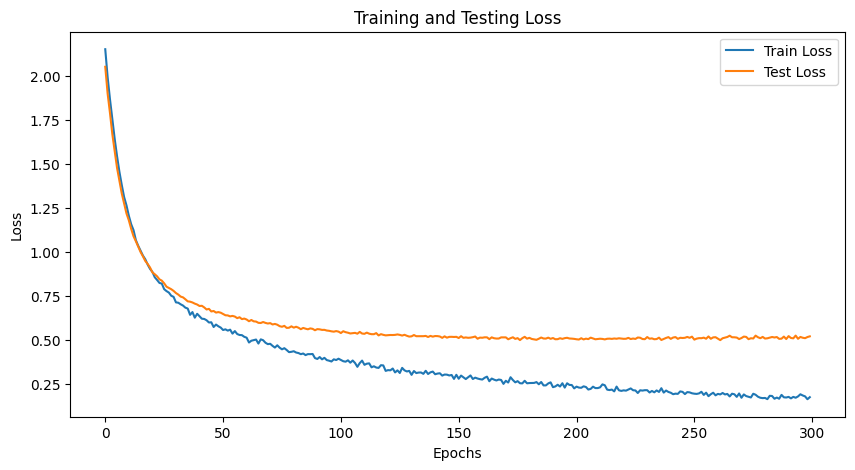

In [12]:



plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


In [21]:
from PIL import Image
import torch
from torchvision import models
import torch.nn as nn

# Correct the image path with forward slashes and the correct image location
image_path = "/content/drive/MyDrive/dataset/test/Vascular lesion/ISIC_0024706.jpg"

img = Image.open(image_path)

# Apply the same transformations to the test image
img = transform(img).unsqueeze(0).to(device)

# Load the saved model
model = models.resnet50(pretrained=True)  # Initialize the ResNet50 model again
num_classes = len(train_dataset.classes)  # Get the number of classes from the training data
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer to match the number of classes
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_fine_tune.pth"))  # Load the saved model weights
model = model.to(device)  # Move the model to the appropriate device (GPU/CPU)

# Set the model to evaluation mode
model.eval()

# Make predictions with the model, ensuring gradients are not calculated
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)

# Get the class labels from the training dataset
class_labels = train_dataset.classes

# Output the predicted class
print(f"Predicted class: {class_labels[predicted.item()]}")


<ipython-input-21-99c293fd0714>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_fine_tune.pth"))  # Load 

Predicted class: Vascular lesion
